<h3> Initial Setup </h3>

In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-01-27 22:05:14,862	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'CPU': 8.0,
 'node:__internal_head__': 1.0,
 'node:192.168.1.209': 1.0,
 'memory': 4632335156.0,
 'accelerator_type:G': 1.0,
 'GPU': 1.0,
 'object_store_memory': 2316167577.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 6
resources_per_worker={"CPU": 1, "GPU": 1/num_workers}

Data Ingestion - With large dataset it is difficult to store whole data in a single computer and with the increased complexity of the LLMs can outperform a single machine so there is a need of distribited system which is achieved by RAY

In [6]:
import pandas as pd


# Data ingestion 
# Ahead we will look how to coninuosly ingest the data from a complex resource such as Datawarehouse.

DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


Data splitting

In [7]:
# splitting the data into train, test, and validation set
from sklearn.model_selection import train_test_split
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [8]:
# splitting the data using the stratify to ensure the equal distribution of the target class variables.

# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=101)

EDA

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [10]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

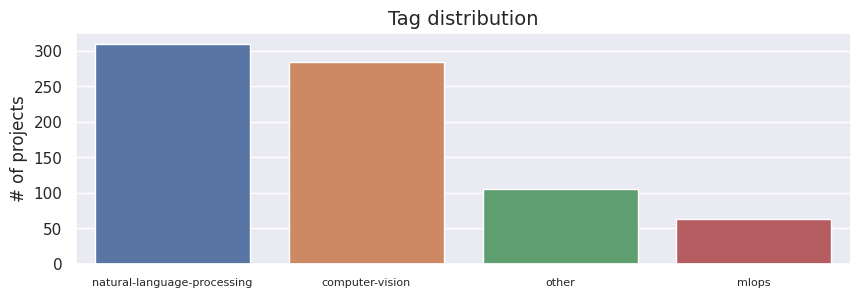

In [11]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()


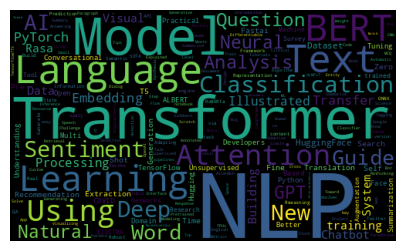

In [12]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Data pre-processing

In [13]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [14]:
# Feature engineering
df["text"] = df.title + " " + df.description

Clean text

In [15]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ppundir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


With larger data sets it is difficult to fit in all the datasets and with increase growing trend in LLM we can easily outgrow our single machine constraints and will need to go distributed. <br>

<h3>We will be using RAY for this</h3>

In [16]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [17]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [18]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


Clean Dataframe

In [19]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


Label encoding

In [20]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'other': 2,
 'natural-language-processing': 3}

In [21]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,0
1,show infer tell contextual inference creative ...,0
2,awesome graph classification collection import...,2
3,awesome monte carlo tree search curated list m...,2
4,attentionwalk pytorch implementation watch ste...,2


In [22]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [23]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

Tokenizer

We will be using pre-trained LLm scibert to tokenize our text.

In [24]:
import numpy as np
from transformers import BertTokenizer

In [25]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [26]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [27]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

Combining all the pre-processing steps into one function

In [28]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [29]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,  2067, 11440, ...,     0,     0,     0],
        [  102, 15598,  3948, ...,     0,     0,     0],
        [  102,  1845,  3687, ...,     0,     0,     0],
        ...,
        [  102, 13302,  7727, ...,     0,     0,     0],
        [  102,  2115,  2712, ...,     0,     0,     0],
        [  102,  4725, 10767, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 2, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3,
        1, 0, 3, 2, 0, 3, 0, 3, 2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 3, 3,
        3, 3, 0, 0, 3, 3, 0, 3, 3, 2, 3, 0, 2, 2, 0, 0, 0, 3, 3, 3, 0, 0,
        3, 0, 3, 0, 0, 1, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 0, 2, 1, 3, 0, 0,
        3, 3, 0, 3, 0, 3, 0, 0, 0, 3, 0, 2, 3, 2, 0, 3, 3, 0, 3, 0, 0, 0,
        0, 3, 3, 3, 0, 0, 3, 2, 0

Distributed pre-processing

In [30]:
from madewithml.data import stratify_split

ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [31]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)


2024-01-27 22:05:27,894	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-01-27 22:05:27,915	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-01-27 22:05:27,919	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-27 22:05:27,920	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:05:27,922	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [32]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-27 22:05:29,842	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-27 22:05:29,843	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:05:29,844	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [34]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-01-27 22:05:30,382	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-01-27 22:05:30,383	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:05:30,384	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([  102,  2158,  2556,  6021,  1968, 13749,  1904, 12662, 14288,
       30111,  9999,   164,  2040,  1968, 13749,  1904,  2556,  6021,
        6076,  1516, 24660, 30131,   103,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


Training of the model

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our [other lessons](https://madewithml.com/#foundations) but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

In [35]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

With the increase in the data and the size of the large language models it is difficult to train the models on a single machine for that we will be using the Ray Train which will handle all the parallel training of the LLM and we do not need to worry about the writing the complex code, and worry about the fault tolerance, etc.

We will be using the BERT model for and will fine tune it as per our data

In [36]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [37]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [38]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

Model

In [39]:
import torch.nn as nn
from transformers import BertModel

In [40]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [42]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [43]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

Batching

In [44]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmpn6ghtvgz
Writing /tmp/tmpn6ghtvgz/_remote_module_non_scriptable.py


In [45]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [46]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [47]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-01-27 22:05:39,005	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-01-27 22:05:39,006	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:05:39,006	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2189,  2782,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0],
         [  102,  5800,  3824,  ...,     0,     0,     0],
         ...,
         [  102,  3241,  1113,  ...,     0,     0,     0],
         [  102, 17444, 30107,  ...,     0,     0,     0],
         [  102,  5590,   123,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([0, 1, 3, 0, 0, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 1, 2, 0, 3,
         0, 1, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 2, 3, 0, 1, 3, 0, 0, 3, 2,
         0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 1, 2, 0, 3, 0, 1, 2, 3, 3, 3, 3,
         2, 3, 3, 3, 3, 1, 3, 0, 2, 3, 0, 0, 0, 0, 2, 

Utilities - we will have the set of necessary functions to enable the distributed training

In [48]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F


In [49]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [50]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [51]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Configurations

In [52]:
from madewithml.config import EFS_DIR

In [61]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 4,
    "num_classes": num_classes,
}

In [62]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [63]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR)

Training

In [64]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-27 22:08:18,828	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-01-27 22:08:18,846	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-27 22:08:18,848	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:08:18,849	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-01-27 22:08:22,523	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]


2024-01-27 22:08:22,525	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:08:22,526	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-01-27 22:08:25,417	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-01-27 22:08:25,421	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:08:25,422	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-01-27 22:08:27,273	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-27 22:08:27,275	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:08:27,276	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-01-27 22:08:30,453	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-27 22:08:30,455	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-27 22:08:30,456	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [66]:
# Dataset config

dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [67]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

2024-01-27 22:08:32,601	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [68]:
%%time
# Train
results = trainer.fit()

2024-01-27 22:08:32,812	INFO data_parallel_trainer.py:407 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(TrainTrainable pid=38668) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(TorchTrainer pid=38668) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=38668) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(TorchTrainer pid=38668) Starting distributed worker processes: ['38707 (192.168.1.209)', '38708 (192.168.1.209)', '38709 (192.168.1.209)', '38710 (192.168.1.209)', '38711 (192.168.1.209)', '38712 (192.168.1.2

TrainingFailedError: The Ray Train run failed. Please inspect the previous error messages for a cause. After fixing the issue (assuming that the error is not caused by your own application logic, but rather an error such as OOM), you can restart the run from scratch or continue this run.
To continue this run, you can use: `trainer = TorchTrainer.restore("/home/ppundir/ray_results/llm")`.
To start a new run that will retry on training failures, set `train.RunConfig(failure_config=train.FailureConfig(max_failures))` in the Trainer's `run_config` with `max_failures > 0`, or `max_failures = -1` for unlimited retries.

(raylet) [2024-01-27 22:09:14,798 E 35711 35711] (raylet) node_manager.cc:3007: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ac4d04c95321f0923265889d6d37a2f3ad8acb3539aba521d5427579, IP: 192.168.1.209) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.1.209`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [ ]:
results

Result(
  metrics={},
  path='/home/ppundir/Desktop/Desktop/mahcine-learning-operations/notebooks/../efs/llm/TorchTrainer_f7624_00000_0_2024-01-27_21-35-57',
  filesystem='local',
  checkpoint=None
)